## Background

Automated Machine Learning (also known as AutoML) refers to techniques for automatically discovering good performance machine learning models with very little user involvement.

Under this category, Hyperopt serves as a Python library that can perform hyper-parameter optimization with Bayesian optimization. It allows large scale of hyper-parameter optimization (e.g. hundreds of parameters).

In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

from hyperopt import hp, tpe, fmin, Trials, space_eval
from functools import partial

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## Hyper-parameter Settings

In [2]:
TEST_SIZE = 0.3
NUM_FOLDS = 2
RANDOM_STATE = 0

## 1. Perform hyper-parameter tuning with hpsklearn wrapper

In [3]:
# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
dataframe = read_csv(url, header=None)

# Split into features and label
data = dataframe.values
X, y = data[:, :-1], data[:, -1]

In [4]:
# Minimally process the dataset
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Define search space
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'),
                          algo=tpe.suggest, max_evals=50, trial_timeout=30)
# Run hyper optimization
print('\n==Run Hyper Optimization of sklearn classifiers==')
model.fit(X_train, y_train)

# Show summary of the best model
print(model.best_model())


==Run Hyper Optimization of sklearn classifiers==
100%|██████████| 50/50 [00:01<00:00,  1.14s/trial, best loss: 0.03448275862068961]
{'learner': KNeighborsClassifier(metric='manhattan', n_jobs=1, n_neighbors=1, p=1), 'preprocs': (StandardScaler(with_mean=False),), 'ex_preprocs': ()}


Test F1-Score: 0.868


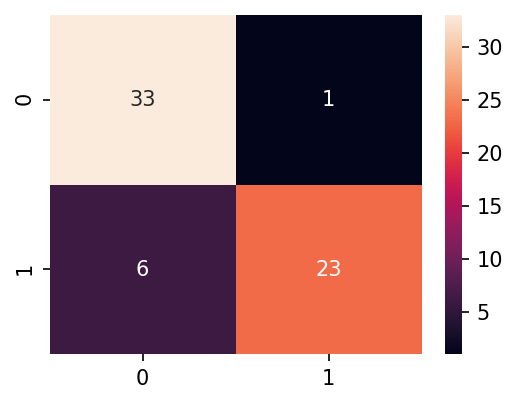

In [6]:
# Show summary of performance
y_pred = model.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Test F1-Score: {round(test_score, 3)}")

cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(dpi=150, figsize=(4, 3))
sns.heatmap(cf_matrix, annot=True)
plt.show()

## 2. Perform hyper-parameter tuning with hyperopt in LGBM model

- Include cross validation during training.

In [7]:
kf = KFold(n_splits=NUM_FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [8]:
def f1_LGBM(PARA, DATA, FMIN, TRAIN):
    
    # Select The Appropriate Data
    y_train = DATA["y_train"]
    X_train = DATA["X_train"]
    y_val = DATA[f"y_test"]
    X_val = DATA[f"X_test"]
    
    # Train Model
    mdl_lgb = lgb.LGBMClassifier(**PARA)  
    
    if FMIN:
        score = cross_val_score(estimator=mdl_lgb, X=X_train, y=y_train, cv=kf, scoring="f1", n_jobs=-1).mean()
        
        return -score
    
    else:
        mdl_lgb.fit(X_train, y_train)
        y_pred = mdl_lgb.predict(X_val)
        score = f1_score(y_val, y_pred)
        
        return score, y_pred

In [9]:
print('\n==Hyper Optimization of LGBM Parameters==')

data_ML = {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            }

# Define search space
lgb_space = {
        'n_estimators': hp.choice('n_estimators', np.unique(np.logspace(np.log10(500), np.log10(1500), 10).astype(int))),
        'num_leaves': hp.choice('num_leaves', np.unique(np.logspace(np.log10(128), np.log10(512), 4).astype(int))),
        'learning_rate': hp.choice('learning_rate', np.logspace(-2, -4, 3)),
        'min_child_weight': hp.choice('min_child_weight', np.logspace(-2, -4, 3)),
        'min_data_in_leaf': hp.choice('min_data_in_leaf', np.unique(np.logspace(np.log10(25), np.log10(80), 5).astype(int))),
        'reg_alpha': hp.choice('reg_alpha', [0,0.3,0.6,0.9]),
        'reg_lambda': hp.choice('reg_lambda', [0,0.3,0.6,0.9]),
        'random_state': hp.choice('random_state', [RANDOM_STATE]),
        'n_jobs': hp.choice('n_jobs', [5])}

func_opti = partial(f1_LGBM, DATA=data_ML, FMIN=True, TRAIN=True) #FMIN = True → -F1 (Because hyperopt wants to minimize)
trials = Trials()

# Run hyper optimization
para_best = fmin(
    fn=func_opti,
    space=lgb_space,
    algo=tpe.suggest,
    return_argmin=False,
    timeout=None,  # How many seconds to run
    verbose=True,
    max_evals=50,  # Max Number of Iterations
    rstate=np.random.RandomState(0),
    trials=trials
)

print("Best Parameters")
print(para_best)

# Show summary of the best LGBM parameters
df_param = pd.DataFrame(para_best, index=['param']).T
df_param


==Hyper Optimization of LGBM Parameters==
100%|██████████| 50/50 [00:07<00:00,  7.01trial/s, best loss: -0.7168843283582089]
Best Parameters
{'learning_rate': 0.01, 'min_child_weight': 0.0001, 'min_data_in_leaf': 33, 'n_estimators': 920, 'n_jobs': 5, 'num_leaves': 127, 'random_state': 0, 'reg_alpha': 0.3, 'reg_lambda': 0.9}


,param
learning_rate,0.0100
min_child_weight,0.0001
min_data_in_leaf,33.0000
n_estimators,920.0000
n_jobs,5.0000
num_leaves,127.0000
random_state,0.0000
reg_alpha,0.3000
reg_lambda,0.9000


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Test F1-Score: 0.842


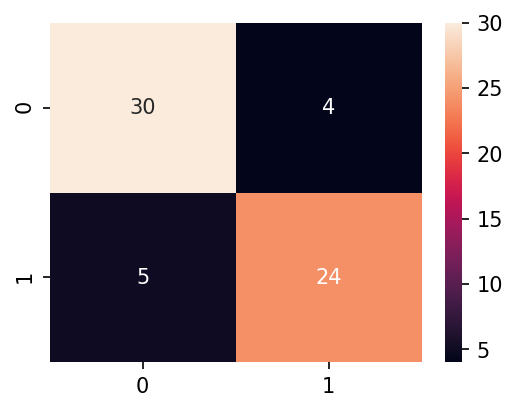

In [10]:
# Show summary of performance
F1_test, y_pred = f1_LGBM(para_best, data_ML, FMIN=False, TRAIN=False)
print(f"Test F1-Score: {round(F1_test, 3)}")

cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(dpi=150, figsize=(4, 3))
sns.heatmap(cf_matrix, annot=True)
plt.show()

In [11]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['min_child_weight'][0],
                      x['misc']['vals']['min_data_in_leaf'][0],
                      x['misc']['vals']['reg_alpha'][0],
                      x['misc']['vals']['reg_lambda'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['loss', 'n_estimators', 'learning_rate', 'min_child_weight', 
                                    'min_data_in_leaf', 'reg_alpha', 'reg_lambda'])

tpe_results_df.reset_index(inplace=True)
tpe_results_df.rename(columns={'index':'iteration'}, inplace=True)

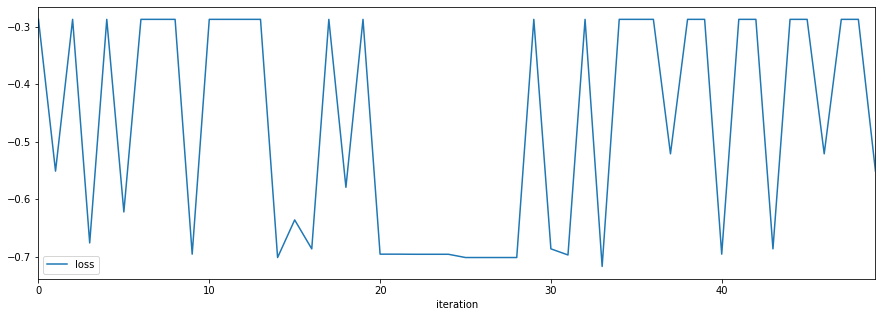

In [12]:
tpe_results_df.plot(kind='line', x='iteration', y='loss', figsize=(15, 5))
plt.show()

---

## Reference

1. https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

## Further Reading

1. https://www.kaggle.com/ilialar/hyperparameters-tunning-with-hyperopt#Hyperopt

2. https://github.com/hyperopt/hyperopt/wiki/FMin